<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from mantisshrimp.all import *

In [2]:
source = Path('/home/lgvaz/.data/PennFudanPed/')

In [3]:
class PersonImageParser(ImageParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        # Get size
        sz = self.lines.filter(lambda o: o.startswith('Image size (X x Y x C)'))[0]
        sz = re.search(r'\d{3,4}\sx\s\d{3,4}\sx\s3', sz).group()
        self.sz = lmap(int, sz.split('x'))
        
    def iid(self, o): return self.i
    def file_path(self, o):
        fp = self.lines.filter(lambda o: o.startswith('Image filename'))[0]
        fp = re.findall(r'"(.*)"', fp)[0]
        return self.source.parent/fp
    
    def width(self, o):  return self.sz[0]
    def height(self, o): return self.sz[1]

In [4]:
class PersonAnnotationParser(AnnotationParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        ln = self.lines.filter(lambda o: o.startswith('Objects with ground truth'))[0]
        self.n = int(re.findall('\d+', ln)[0])
        
    def iid(self, o): return self.i
    def oid(self, o): return [1]*self.n
    def iscrowd(self, o): return [0]*self.n
        
    def bbox(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Bounding box'))
        bboxes = []
        for bbox in lines:
            bbox = re.findall(r'(\d+,\s\d+)', bbox)
            bbox = lmap(lambda o: lmap(int, o.split(',')), bbox)
            bbox = np.array(bbox).flat
            bboxes.append(BBox.from_xyxy(*bbox))
        return bboxes
    
    def seg(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Pixel mask for object'))
        line = lines[0] # All lines contain the same mask
        fp = self.source.parent/re.findall(r'"(.+)"', line.split(':')[-1])[0]
        return MaskFile(fp)

In [5]:
class PersonParser(DataParser):
    def get_img_parser(self, o, source): return PersonImageParser(o, source)
    def get_annot_parser(self, o, source): return PersonAnnotationParser(o, source)

In [6]:
fns = get_files(source/'Annotation', extensions='.txt')

In [7]:
parser = PersonParser(fns, source)
records = parser.parse()


Removed 0 images that don't have annotations


In [8]:
r = records[0]

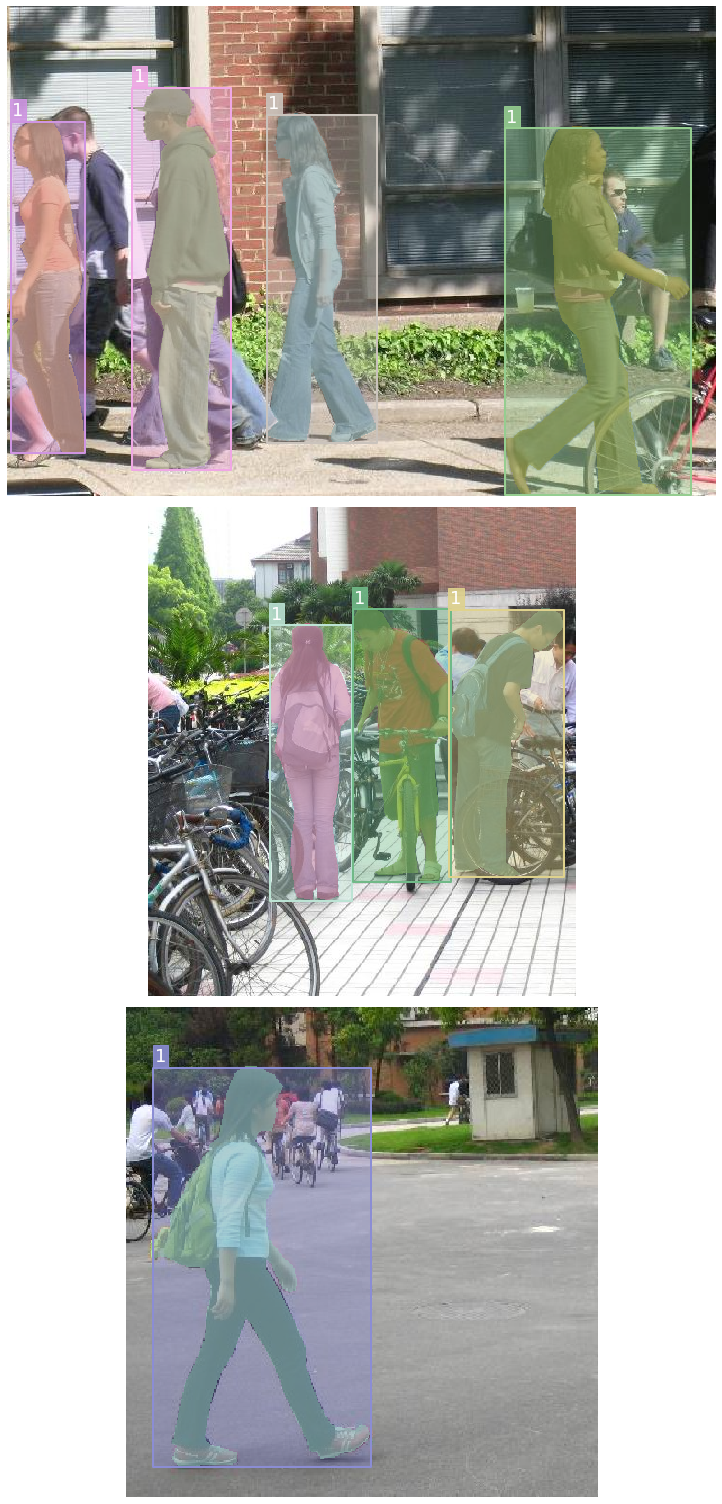

In [9]:
grid(partial(show_record, bbox=True), records[42:45])

In [10]:
def zip_collate(t): return tuple(zip(*t))

In [11]:
class MyDataset:
    def __init__(self, records, tfms): self.records,self.tfms = records,tfms
    def __len__(self): return len(self.records)
    def __getitem__(self, i):
        im,rec = self.tfms(self.records[i])
        return im2tensor(im), rec.to_rcnn_target()

In [12]:
tfms = AlbumentationTransformer([A.HorizontalFlip(p=1)])

In [13]:
ds = MyDataset(records, tfms)
dl = DataLoader(ds, batch_size=2, shuffle=True, collate_fn=zip_collate, num_workers=8)

In [14]:
xb,yb = first(dl)

In [15]:
[o.shape for o in xb]

[torch.Size([3, 438, 567]), torch.Size([3, 349, 292])]

In [16]:
import pytorch_lightning as pl
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

class Model(pl.LightningModule):
    def __init__(self, n_class):
        super().__init__()
        self.m = self.get_model_instance_segmentation(n_class)
        
    def forward(self, x): return self.m(x)
    
    def training_step(self, b, b_idx):
        x,y = b
        losses = self.m(x,list(y))
        loss = sum(losses.values())
        return {'loss': loss, 'log': losses}
        
    def get_model_instance_segmentation(self, n_class, h=256):
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_class)
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, h, n_class)
        return model
    
    def configure_optimizers(self):
        params = [p for p in model.parameters() if p.requires_grad]
        opt = torch.optim.SGD(params, 5e-3, momentum=0.9, weight_decay=0.0005)
        step_lr = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)
        return [opt], [step_lr]

In [17]:
model = Model(2)

In [18]:
trainer = pl.Trainer(max_epochs=2, gpus=1)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [19]:
trainer.fit(model, dl)

INFO:lightning:
    | Name                                       | Type                     | Params
------------------------------------------------------------------------------------
0   | m                                          | MaskRCNN                 | 43 M  
1   | m.transform                                | GeneralizedRCNNTransform | 0     
2   | m.backbone                                 | BackboneWithFPN          | 26 M  
3   | m.backbone.body                            | IntermediateLayerGetter  | 23 M  
4   | m.backbone.body.conv1                      | Conv2d                   | 9 K   
5   | m.backbone.body.bn1                        | FrozenBatchNorm2d        | 0     
6   | m.backbone.body.relu                       | ReLU                     | 0     
7   | m.backbone.body.maxpool                    | MaxPool2d                | 0     
8   | m.backbone.body.layer1                     | Sequential               | 212 K 
9   | m.backbone.body.layer1.0                   

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


1